In [1]:
import numpy
import scipy
from matplotlib import pyplot
from mpl_toolkits.basemap import Basemap
import matplotlib.colors
nicebwr = matplotlib.colors.LinearSegmentedColormap.from_list("nicebwr",["#094da0","#FFFFFF","#ef1a2d"])
import scha
import importlib
import bspline
import xyzfield
%load_ext memory_profiler

cos = numpy.cos; sin = numpy.sin

%matplotlib nbagg

### datos

vamos a coger todos los datos de **geomagia** del universo.

ok

In [2]:
super_datos = numpy.loadtxt("/home/josecper/Programs/data/scha/pruebas/archeo019.csv", skiprows=2, delimiter=",", usecols=(0, 3, 5, 6, 8, 9))

In [3]:
def angulardist(theta1, phi1, theta2, phi2):
    return numpy.arccos(sin(theta1)*sin(theta2)*cos(phi1 - phi2)+cos(theta1)*cos(theta2))

In [4]:
super_datos[(super_datos == -999) | (super_datos == 999)] = numpy.nan

theta_c, phi_c, theta_0d, theta_0 = numpy.deg2rad((90-45.0, 15.0, 20.0, 20.0))

lat, lon = (super_datos.T[-2], super_datos.T[-1])
super_datos = super_datos[~numpy.isnan(lat) & ~numpy.isnan(lon)]

thetav, phiv = numpy.deg2rad((90-super_datos.T[4], super_datos.T[5]))
inside_cap = angulardist(thetav, phiv, theta_c, phi_c) < theta_0d
super_datos = super_datos[inside_cap]

thetav, phiv = numpy.deg2rad((90-super_datos.T[4], super_datos.T[5]))
times, F_orig, D_orig, I_orig = super_datos.T[:4]

D_orig, I_orig = numpy.deg2rad((D_orig, I_orig))

del super_datos

### rotación

primero las coordenadas

In [5]:
rot_mat = scha.rotation_matrix(theta_c, phi_c, invert=True)
r, theta_r, phi_r = scha.rotate_coords(1.0, thetav, phiv, rot_mat)

ahora los vectores

In [6]:
D_rot = scha.rotate_declination(D_orig, theta_c, phi_c, thetav, phiv, theta_r)

### inversión

calculamos las raíces de los armónicos e invertimos la cosa

In [7]:
ms = numpy.arange(0, 10);
roots = scha.degree(ms, theta0 = theta_0, max_k = 9)
k, m, n = scha.join_roots(roots)

knots = numpy.linspace(-1000, 2000, 10)

In [9]:
importlib.reload(scha); importlib.reload(bspline)
gp=scha.invert_dift(theta_r, phi_r, times, D_rot, I_orig, F_orig, (k, m, n), knots, g0=None, steps=25)

iteration 25  : rms = 0.531138718177

<IPython.core.display.Javascript object>


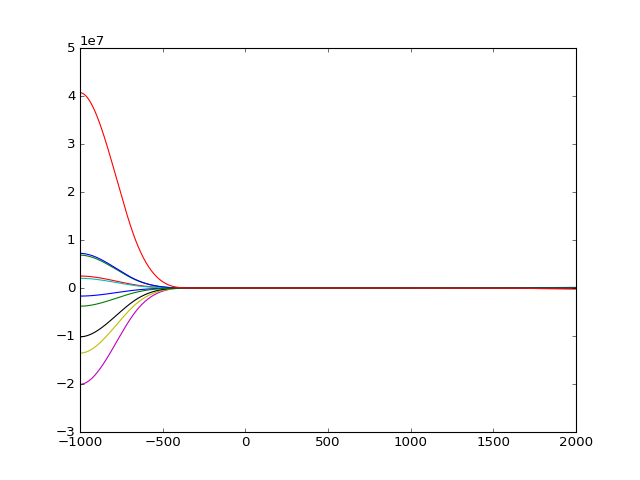

In [10]:
tt = numpy.linspace(-1000, 2000, 1000)
big=bspline.condition_array(knots, tt) @ gp

fig, ax = pyplot.subplots()

for knot, gc in zip(knots, big.T):
    ax.plot(tt, gc)
    ax.plot([knot, knot], [-80000, 80000], "k--")
    
ax.set_xbound(-1000, 2000)

<IPython.core.display.Javascript object>


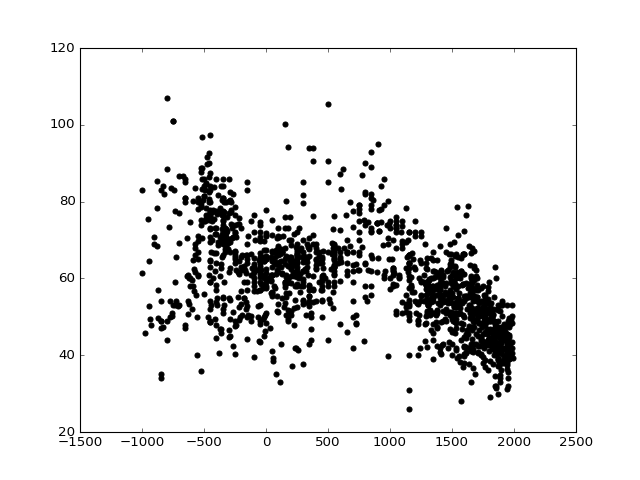

In [11]:
fig, ax = pyplot.subplots()

ax.scatter(times, F_orig, color="black")

pyplot.show(fig)

In [12]:
Bx_inv, By_inv, Bz_inv = scha.xyzfieldt(k, m, n, knots, gp, theta_r, phi_r, times)

In [13]:
D_inv, I_inv, F_inv, H_inv = xyzfield.xyz2difh(Bx_inv, By_inv, Bz_inv)

<IPython.core.display.Javascript object>


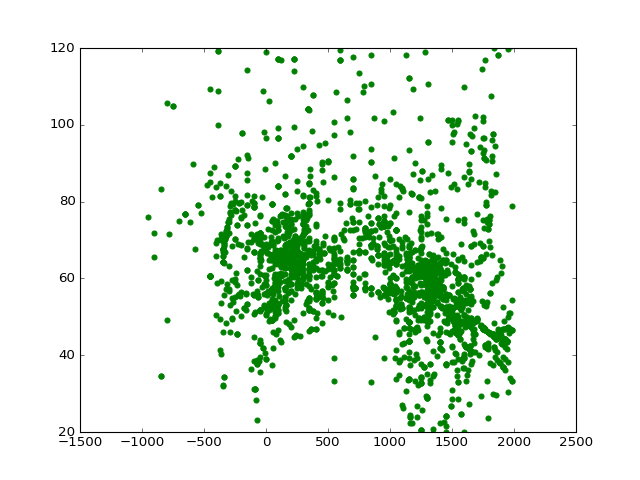

In [14]:
fig, ax = pyplot.subplots()

ax.scatter(times, F_inv, color="green")
ax.set_xbound(-1500, 2500)
ax.set_ybound(20, 120)

pyplot.show(fig)